# **G18 Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift**

Following section "4 Experiments: Activations over time"  from the paper written by Sergey Ioffe Christian Szegedy (2015), we have the following parameters:

*  28x28 binary image as input
*  3 fully-connected hidden layers with 100 activations each
*  Each hidden layer computes y = g(W u+b) with sigmoid nonlinearity, and the weights W initialized to small random Gaussian values. The last hidden layer is followed by a fully-connected layer with 10 activations (one per class) and cross-entropy loss. Each hidden layer performs Batch Normalization.
*  Training: 50000 steps, with 60 examples per mini-batch.


In [ ]:
!pip install python-mnist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import time
import json
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5


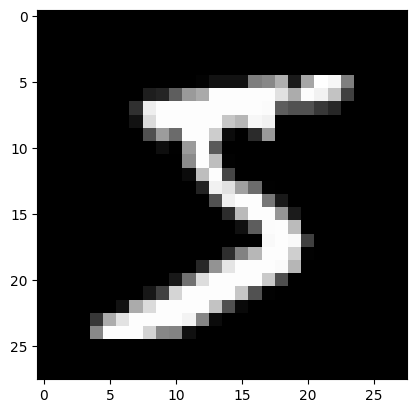

In [ ]:
#load mnist data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[0], cmap='gray')
print(train_labels[0])

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
class BatchNormLayer(keras.layers.Layer):
    def __init__(self, units=100, batch_size = 60):
        super().__init__()
        self.units = units
        self.batch_size = batch_size

    def build(self, input_shape):
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=keras.initializers.RandomNormal(mean=1.0, stddev=0.01),
            trainable=True
        )

        # Non-trainable parameters for inference
        self.moving_mean = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=False)
        self.moving_var = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=False)

        # Initialize tracking variables
        self.total_mean = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=False)
        self.total_variance = self.add_weight(shape=(input_shape[-1],),initializer="ones",trainable=False)
        self.batch_count = self.add_weight(shape=(), initializer="zeros",trainable=False, dtype=tf.int32)

    def call(self, inputs,training=False): #Training is handled by keras, while .fit is True and in .predict is False
        e = 1e-3 #small constant to avoid division by zero

        if training:
          #Batch Normalizing Transform (Algorithm 1)
          meanB = tf.math.reduce_mean(inputs, axis=0) #mini-batch mean
          varB = tf.math.reduce_variance(inputs, axis=0) #mini-batch variance
          #x_norm = (inputs-meanB)/(tf.math.sqrt(varB+e)) #normalize
          #y = self.gamma*x_norm + self.beta #scale and shift

          #update
          self.total_mean.assign_add(meanB)
          self.total_variance.assign_add(varB)
          self.batch_count.assign_add(1)

          # Train Inference BN network with frozen parameters
          # Current population estimates
          m = tf.cast(self.batch_size, tf.float32)
          pop_mean = self.total_mean / tf.cast(self.batch_count, tf.float32)
          pop_var = (self.total_variance / tf.cast(self.batch_count, tf.float32)) * (m/(m - 1))
          self.moving_mean.assign(pop_mean)
          self.moving_var.assign(pop_var)
          # Normalize using batch statistics
          x_norm = (inputs - meanB) / tf.sqrt(varB + e)
          return self.gamma * x_norm + self.beta

        else:
          # Normalize using population statistics
          scale = self.gamma / tf.sqrt(self.moving_var + e)
          shift = self.beta - (self.gamma * self.moving_mean) / tf.sqrt(self.moving_var + e)
          y = scale * inputs + shift

          return y



class PercentileLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer_name, validation_data):
        super().__init__()
        self.layer_name = layer_name
        self.validation_data = validation_data
        self.percentiles = []  # Stores [epoch, p15, p50, p85]
        self.seen = 0

    def on_batch_end(self, batch, logs=None):
        # Buscar la capa por nombre
        if self.seen % 100 == 0:
          layer_output = self.model.get_layer(self.layer_name).output
          intermediate_model = tf.keras.Model(self.model.input, layer_output)

          val_inputs = self.validation_data[0]
          output_data = intermediate_model.predict(val_inputs, verbose=0)

          p15 = np.percentile(output_data, 15)
          p50 = np.percentile(output_data, 50)
          p85 = np.percentile(output_data, 85)

          self.percentiles.append([batch, p15, p50, p85])
          print(f" Batch {batch+1}: P15={p15:.3f}, P50={p50:.3f}, P85={p85:.3f}")
        self.seen += 1


In [ ]:
### Training parameters
batch_size = 60
steps = 50000
epochs = steps // (len(train_images) // batch_size)


In [ ]:

## Build the BN model
inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal', name='last_hidden')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)


model_BN = keras.Model(inputs=inputs, outputs=outputs)

model_BN.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# To keep track of percentiles
percentile_logger_BN = PercentileLogger(layer_name="last_hidden", validation_data=(test_images, test_labels))



In [ ]:
# Keep track of training time
start_time = time.time()

# Train
history_model_BN = model_BN.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    callbacks=[percentile_logger_BN]
)

end_time = time.time()
BN_time = end_time - start_time
print(f"Training time for Batch Normalization Model: {BN_time} seconds")


Epoch 1/50
 Batch 1: P15=-0.236, P50=-0.013, P85=0.227
  94/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.0876 - loss: 2.3859 Batch 101: P15=-0.252, P50=-0.007, P85=0.264
 197/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.1227 - loss: 2.3266 Batch 201: P15=-0.254, P50=-0.006, P85=0.270
 298/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.1630 - loss: 2.2731 Batch 301: P15=-0.255, P50=-0.006, P85=0.273
 399/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.2017 - loss: 2.2254 Batch 401: P15=-0.257, P50=-0.005, P85=0.276
 489/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2335 - loss: 2.1870 Batch 501: P15=-0.258, P50=-0.004, P85=0.278
 588/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2652 - loss: 2.1484 Batch 601: P15=-0.260, P50=-0.004, P85=0.279
 689/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2939 - loss: 2.1123 Batch 701: P15=-0.261, P50=-0.003, P85=0.281
 790/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3194 - loss: 2.0793 Ba

In [ ]:
## Build Base model
inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal', name='last_hidden')(x)
x = keras.layers.Activation('sigmoid')(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)

model_base = keras.Model(inputs=inputs, outputs=outputs)

model_base.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Keep track of percentiles
percentile_logger = PercentileLogger(layer_name="last_hidden", validation_data=(test_images, test_labels))


In [ ]:

# Keep track of training time
start_time = time.time()

# Train
history_model_base = model_base.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=60,
    validation_data=(test_images, test_labels),
    callbacks=[percentile_logger]
)

end_time = time.time()
base_time = end_time - start_time
print(f"Training time for Base Model: {base_time} seconds")

Epoch 1/50
 Batch 1: P15=-0.326, P50=0.072, P85=0.279
  98/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1076 - loss: 2.3451 Batch 101: P15=-0.322, P50=0.057, P85=0.290
 188/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1081 - loss: 2.3305 Batch 201: P15=-0.321, P50=0.058, P85=0.292
 294/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1092 - loss: 2.3224 Batch 301: P15=-0.320, P50=0.059, P85=0.288
 396/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1104 - loss: 2.3178 Batch 401: P15=-0.320, P50=0.057, P85=0.287
 490/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1114 - loss: 2.3149 Batch 501: P15=-0.320, P50=0.055, P85=0.287
 596/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1123 - loss: 2.3124 Batch 601: P15=-0.319, P50=0.057, P85=0.283
 696/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1131 - loss: 2.3105 Batch 701: P15=-0.318, P50=0.056, P85=0.285
 797/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1139 - loss: 2.3090 Batch 801: P15=-

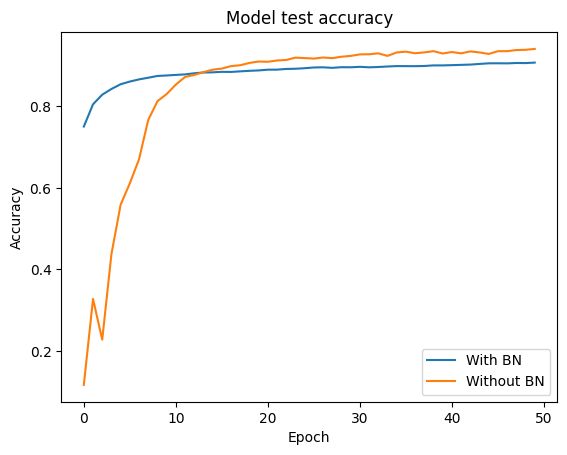

In [ ]:
# Models Test Accuracy
plt.plot(history_model_BN.history['val_accuracy'])
plt.plot(history_model_base.history['val_accuracy'])
plt.title('Model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With BN', 'Without BN'], loc='lower right')
plt.show()

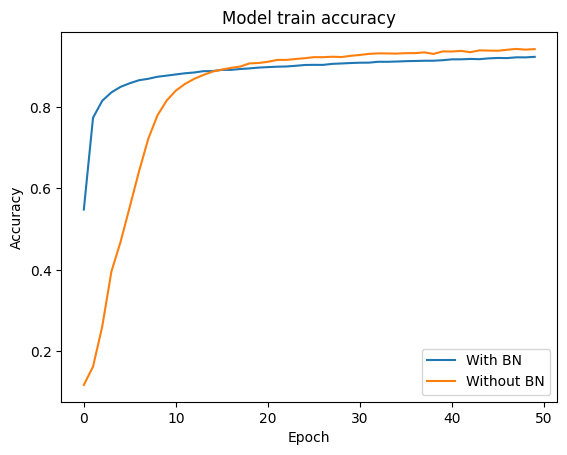

In [ ]:
# Models train Accuracy
plt.plot(history_model_BN.history['accuracy'])
plt.plot(history_model_base.history['accuracy'])
plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With BN', 'Without BN'], loc='lower right')
plt.show()

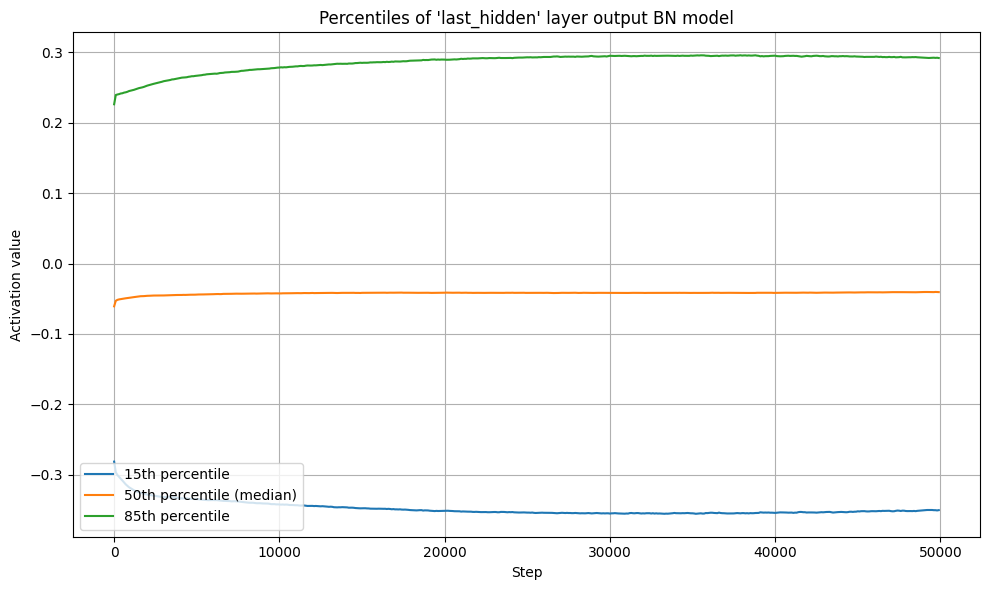

In [ ]:

# Getting percentiles for BN model
percentiles_array = np.array(percentile_logger_BN.percentiles)
raw_steps = percentiles_array[:, 0]
epochs = percentiles_array[:, 0]
p15 = percentiles_array[:, 1]
p50 = percentiles_array[:, 2]
p85 = percentiles_array[:, 3]
fixed_steps = np.array([i + epoch * 1000 for epoch in range(50)
                        for i in raw_steps[:10]])
epochs = fixed_steps
plt.figure(figsize=(10, 6))
plt.plot(epochs, p15, label='15th percentile')
plt.plot(epochs, p50, label='50th percentile (median)')
plt.plot(epochs, p85, label='85th percentile')

plt.title("Percentiles of 'last_hidden' layer output BN model")
plt.xlabel("Step")
plt.ylabel("Activation value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


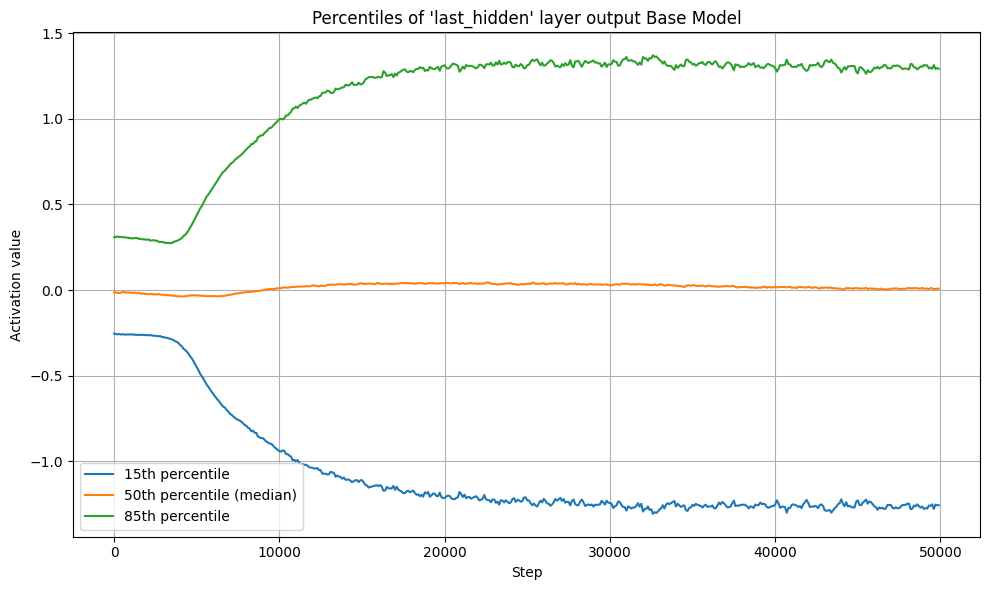

In [ ]:
# Getting percentiles for base model
percentiles_array = np.array(percentile_logger.percentiles)
raw_steps = percentiles_array[:, 0]
epochs = percentiles_array[:, 0]
p15 = percentiles_array[:, 1]
p50 = percentiles_array[:, 2]
p85 = percentiles_array[:, 3]
fixed_steps = np.array([i + epoch * 1000 for epoch in range(50)
                        for i in raw_steps[:10]])
epochs = fixed_steps
plt.figure(figsize=(10, 6))
plt.plot(epochs, p15, label='15th percentile')
plt.plot(epochs, p50, label='50th percentile (median)')
plt.plot(epochs, p85, label='85th percentile')

plt.title("Percentiles of 'last_hidden' layer output Base Model")
plt.xlabel("Step")
plt.ylabel("Activation value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 2400x1500 with 0 Axes>

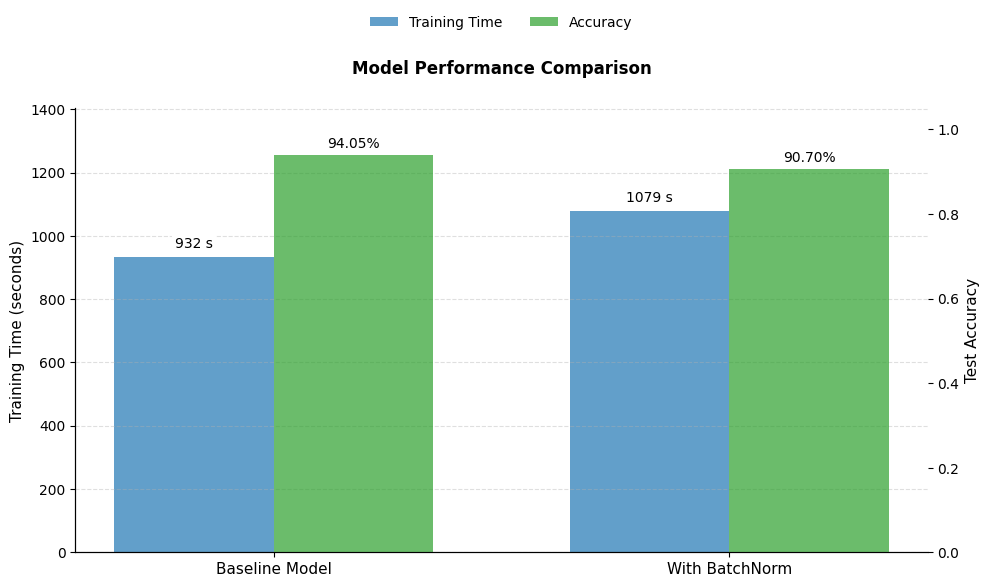

In [ ]:
# Models training time and max accuracy
base_accuracy = history_model_base.history['val_accuracy'][-1]  # Last validation accuracy
BN_accuracy = history_model_BN.history['val_accuracy'][-1]  # Last validation accuracy

# Create figure with constrained layout
plt.figure(figsize=(8, 5), dpi=300)


# Main axis
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax1.set_facecolor('white')

x_pos = np.array([0, 1])  # Positions for models
width = 0.35  # Width of each bar

# Time bars (left axis)
time_bars = ax1.bar(x_pos - width/2, [base_time, BN_time],
                   width=width, color=['#1f77b4', '#1f77b4'],
                   alpha=0.7, label='Training Time')

# Accuracy bars (right axis)
ax2 = ax1.twinx()
acc_bars = ax2.bar(x_pos + width/2, [base_accuracy, BN_accuracy],
                 width=width, color=['#2ca02c', '#2ca02c'],
                 alpha=0.7, label='Accuracy')

# ====== ENHANCED LABELING ======
# Time labels (left)
for bar in time_bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 20,
            f'{height:.0f} s',
            ha='center', va='bottom', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', pad=2))

# Accuracy labels (right)
for bar in acc_bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', pad=2))

# ====== AXIS CUSTOMIZATION ======
ax1.set_ylabel('Training Time (seconds)', fontsize=11)
ax2.set_ylabel('Test Accuracy', fontsize=11)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Baseline Model', 'With BatchNorm'], fontsize=11)

# ====== PROFESSIONAL TOUCHES ======
# 1. Limit axis ranges
ax1.set_ylim(0, max(base_time, BN_time)*1.3)
ax2.set_ylim(0, 1.05)

# 2. Add horizontal grid lines
ax1.yaxis.grid(True, linestyle='--', alpha=0.4)

# 3. Clean spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 4. Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
          loc='lower center', bbox_to_anchor=(0.5, 1.15),
          ncol=2, frameon=False, fontsize=10)

# 5. Title with padding
plt.title('Model Performance Comparison',
         pad=25, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


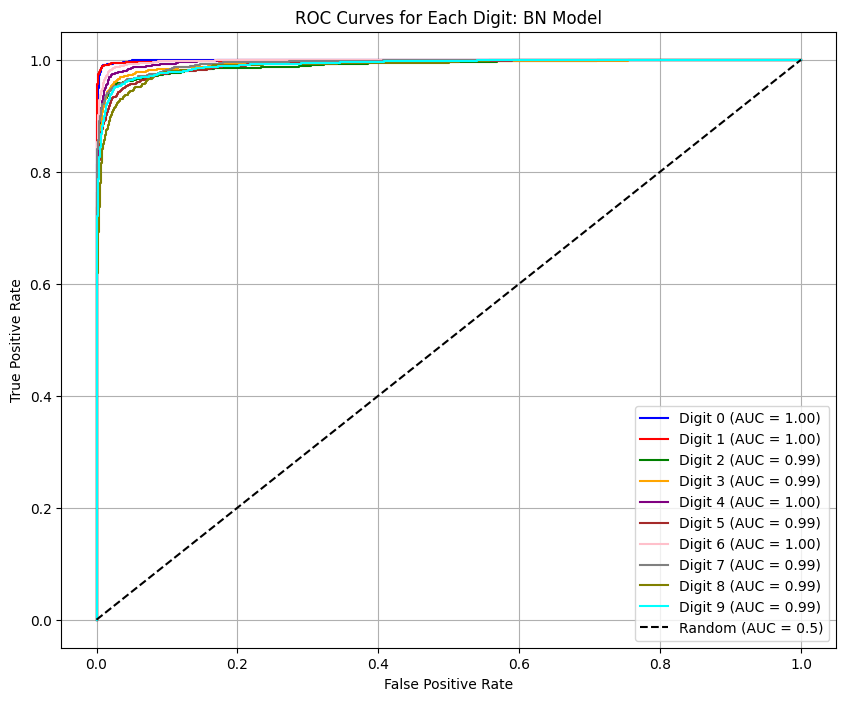

In [ ]:
# Second measurment metric
# We will plot the ROC curve for each class

# Convert true labels to one-hot encoded format
y_true_bin = label_binarize(test_labels, classes=np.arange(10))  # Shape: (n_samples, 10)

# BN model
y_probs_BN = model_BN.predict(test_images)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple',
          'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_BN[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'Digit {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Digit: BN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


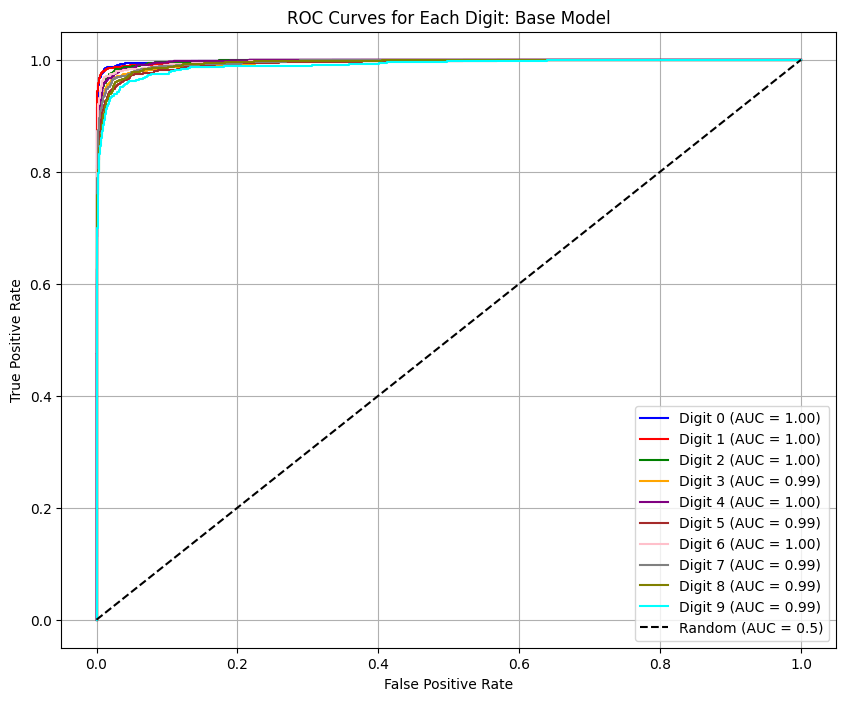

In [ ]:
# Base model
y_probs_base = model_base.predict(test_images)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple',
          'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'Digit {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Digit: Base Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---
# **Different Batch Size**

In [ ]:
# For this part we ar using only 10% of the data for a faster training
sample = range(0,60000)
train_samples = random.sample(sample,6000)
train_images_samples = train_images[train_samples]
train_labels_samples = train_labels[train_samples]

In [ ]:
len(train_images_samples)

6000

In [ ]:
sample = range(0,10000)
test_samples = random.sample(sample,1000)
test_images_samples = test_images[test_samples]
test_labels_samples = test_labels[test_samples]

In [ ]:
len(test_images_samples)

1000

In [ ]:
### Training parameters

batch_size = [1,5,8,16,32]
steps = 5000


In [ ]:

ac_list = []
loss_list = []
time_list = []

for bs in batch_size:
  # Keep track of training time
  start_time = time.time()


  # Train
  history_model_BN = model_BN.fit(
      train_images_samples, train_labels_samples,
      epochs=10,
      batch_size=bs,
      validation_data=(test_images_samples, test_labels_samples),
      callbacks=[percentile_logger_BN]
  )
  end_time = time.time()
  base_time = end_time - start_time
  time_list.append(base_time)
  loss_list.append(history_model_BN.history['val_loss'][-1])
  ac_list.append(history_model_BN.history['val_accuracy'][-1])




Epoch 1/10
 Batch 1: P15=-0.305, P50=0.049, P85=0.376
 100/6000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.1547 - loss: 2.3218 Batch 101: P15=-0.306, P50=0.049, P85=0.377
 177/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - accuracy: 0.1457 - loss: 2.3170  Batch 201: P15=-0.307, P50=0.049, P85=0.379
 278/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - accuracy: 0.1376 - loss: 2.3150  Batch 301: P15=-0.308, P50=0.049, P85=0.380
 375/6000 ━━━━━━━━━━━━━━━━━━━━ 1:05 12ms/step - accuracy: 0.1333 - loss: 2.3129 Batch 401: P15=-0.309, P50=0.049, P85=0.381
 500/6000 ━━━━━━━━━━━━━━━━━━━━ 1:07 12ms/step - accuracy: 0.1289 - loss: 2.3118 Batch 501: P15=-0.310, P50=0.049, P85=0.381
 576/6000 ━━━━━━━━━━━━━━━━━━━━ 1:12 13ms/step - accuracy: 0.1273 - loss: 2.3114 Batch 601: P15=-0.310, P50=0.049, P85=0.382
 678/6000 ━━━━━━━━━━━━━━━━━━━━ 1:08 13ms/step - accuracy: 0.1255 - loss: 2.3109 Batch 701: P15=-0.310, P50=0.049, P85=0.382
 800/6000 ━━━━━━━━━━━━━━━━━━━━ 1:03 12ms/step - accuracy: 0.1240 - loss: 2.3101 

In [ ]:
result = {
    'batch_size': batch_size,
    'accuracy': ac_list,
    'val_loss': loss_list,
    'time': time_list
}

In [ ]:
#Saving training history

with open('training_history.json', 'w+') as file:
    json.dump(result, file)

 **Plot for different Batch size**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Batch_Normalization_result.json to Batch_Normalization_result.json


In [ ]:
# reading training history
import json
with open('Batch_Normalization_result.json', 'r') as file:
    loaded_history = json.load(file)

In [ ]:
loaded_history["batch_size"]

[1, 5, 8, 16, 32]

In [ ]:
loaded_history["val_loss"]

[2.5279557704925537,
 0.529597818851471,
 0.5071282386779785,
 0.5004997253417969,
 0.4980039894580841]

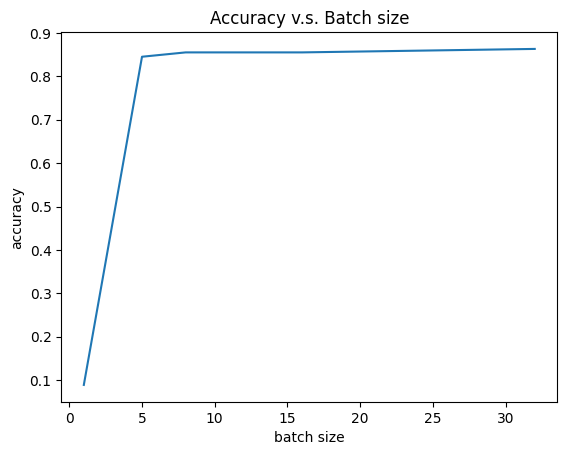

In [ ]:

plt.plot(loaded_history["batch_size"], loaded_history["accuracy"])
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.title("Accuracy v.s. Batch size")
plt.show()

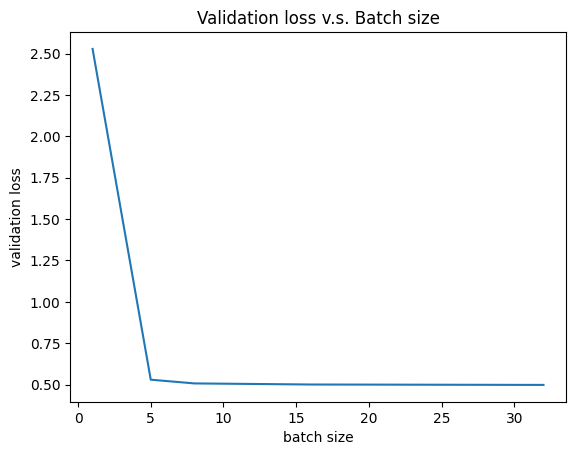

In [ ]:

plt.plot(loaded_history["batch_size"], loaded_history["val_loss"])
plt.xlabel("batch size")
plt.ylabel("validation loss")
plt.title("Validation loss v.s. Batch size")
plt.show()

---
# Layer normalization

Possible improvement to be able to use small batch size.

In [ ]:

# Assuming PercentileLogger is a custom callback you have defined
# If not, you'll need to either define it or remove it for this example to run

inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = layers.LayerNormalization()(x)  # Replace BatchNormLayer with layers.LayerNormalization
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal')(x)
x = layers.LayerNormalization()(x)  # Replace BatchNormLayer with layers.LayerNormalization
x = keras.layers.Activation('sigmoid')(x)

x = keras.layers.Dense(100, kernel_initializer='random_normal', name='last_hidden')(x)
x = layers.LayerNormalization()(x)  # Replace BatchNormLayer with layers.LayerNormalization
x = keras.layers.Activation('sigmoid')(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)

model_LN = keras.Model(inputs=inputs, outputs=outputs)  # Renamed the model to model_LN for clarity

model_LN.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# To keep track of percentiles - Assuming PercentileLogger works with standard Keras layers
percentile_logger_LN = PercentileLogger(layer_name="last_hidden", validation_data=(test_images, test_labels))



In [ ]:

batch_size = [1,5,8,16,32]
steps = 5000

In [ ]:
ac_list = []
loss_list = []
time_list = []

for bs in batch_size:
  ##epochs = steps // (len(train_images) // bs)
  # Keep track of training time
  start_time = time.time()


  # Train
  history_model_LN = model_LN.fit(
      train_images_samples, train_labels_samples,
      epochs=10,
      batch_size=bs,
      validation_data=(test_images_samples, test_labels_samples),
      callbacks=[percentile_logger_LN]
  )
  end_time = time.time()
  base_time = end_time - start_time
  time_list.append(base_time)
  loss_list.append(history_model_LN.history['val_loss'][-1])
  ac_list.append(history_model_LN.history['val_accuracy'][-1])

Epoch 1/10
 Batch 1: P15=-0.262, P50=-0.046, P85=0.274
 100/6000 ━━━━━━━━━━━━━━━━━━━━ 6:21 65ms/step - accuracy: 0.0964 - loss: 2.3314 Batch 101: P15=-0.273, P50=-0.030, P85=0.266
 200/6000 ━━━━━━━━━━━━━━━━━━━━ 7:52 81ms/step - accuracy: 0.1068 - loss: 2.3594 Batch 201: P15=-0.283, P50=-0.016, P85=0.273
 300/6000 ━━━━━━━━━━━━━━━━━━━━ 8:15 87ms/step - accuracy: 0.1151 - loss: 2.3575 Batch 301: P15=-0.282, P50=-0.021, P85=0.277
 400/6000 ━━━━━━━━━━━━━━━━━━━━ 8:23 90ms/step - accuracy: 0.1214 - loss: 2.3512 Batch 401: P15=-0.271, P50=-0.023, P85=0.265
 500/6000 ━━━━━━━━━━━━━━━━━━━━ 8:23 92ms/step - accuracy: 0.1250 - loss: 2.3459 Batch 501: P15=-0.272, P50=-0.019, P85=0.263
 600/6000 ━━━━━━━━━━━━━━━━━━━━ 8:35 95ms/step - accuracy: 0.1266 - loss: 2.3420 Batch 601: P15=-0.290, P50=-0.010, P85=0.278
 699/6000 ━━━━━━━━━━━━━━━━━━━━ 8:39 98ms/step - accuracy: 0.1268 - loss: 2.3388 Batch 701: P15=-0.282, P50=-0.010, P85=0.269
 800/6000 ━━━━━━━━━━━━━━━━━━━━ 8:28 98ms/step - accuracy: 0.1271 - los

In [ ]:
result_LN = {
    'batch_size': batch_size,
    'accuracy': ac_list,
    'val_loss': loss_list,
    'time': time_list
}

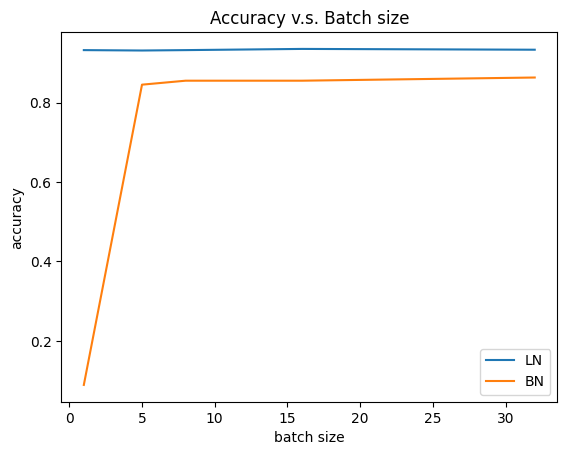

In [ ]:
plt.plot(result_LN["batch_size"], result_LN["accuracy"])
plt.plot(loaded_history["batch_size"], loaded_history["accuracy"])
plt.title("Accuracy v.s. Batch size")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend(['LN', 'BN'], loc='lower right')
plt.show()

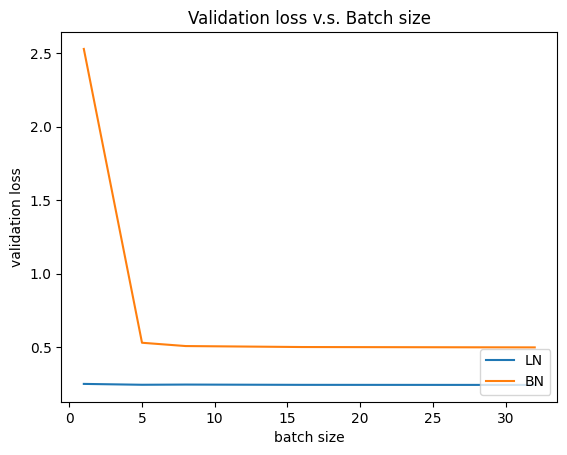

In [ ]:
plt.plot(result_LN["batch_size"], result_LN["val_loss"])
plt.plot(loaded_history["batch_size"], loaded_history["val_loss"])
plt.xlabel("batch size")
plt.ylabel("validation loss")
plt.title("Validation loss v.s. Batch size")
plt.legend(['LN', 'BN'], loc='lower right')
plt.show()

---
# **Weight Standardization**

In [ ]:

class WeightStandardizationDense(keras.layers.Layer):
    def __init__(self, units,kernel_initializer ,**kwargs):
        super(WeightStandardizationDense, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        self.kernel_shape = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer=self.kernel_initializer,
            trainable=True
        )
        self.built = True

    def call(self, inputs):
        kernel = self.kernel_shape
        kernel_mean = tf.math.reduce_mean(kernel, axis=0, keepdims=True, name='kernel_mean')
        kernel = kernel - kernel_mean
        kernel_std = tf.keras.backend.std(kernel, axis=0, keepdims=True)
        kernel = kernel / (kernel_std + 1e-5)
        return K.dot(inputs, kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = super(WeightStandardizationDense, self).get_config()
        config.update({
            'units': self.units,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer)
        })
        return config

class WSDense(keras.layers.Layer):
    def __init__(self, units, activation=None, use_bias=True,
                 kernel_initializer='random_normal',
                 bias_initializer='zeros', **kwargs):
        super(WSDense, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.ws = WeightStandardizationDense(units=units,kernel_initializer=self.kernel_initializer) # Pass initializer

    def build(self, input_shape):
        self.ws.build(input_shape)
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                trainable=True,
                name='bias'
            )
        self.input_spec = keras.layers.InputSpec(ndim=2, axes={-1: input_shape[-1]})
        self.built = True

    def call(self, inputs):
        output = self.ws(inputs)
        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = super(WSDense, self).get_config()
        config.update({
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer)
        })
        return config

In [ ]:
inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = WSDense(100, kernel_initializer='random_normal')(x)
x = keras.layers.Activation('sigmoid')(x)

x = WSDense(100, kernel_initializer='random_normal')(x)
x = keras.layers.Activation('sigmoid')(x)

x = WSDense(100, kernel_initializer='random_normal',name='last_hidden')(x)
x = keras.layers.Activation('sigmoid')(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)

model_WS = keras.Model(inputs=inputs, outputs=outputs)  # Renamed the model to model_LN for clarity

model_WS.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# To keep track of percentiles - Assuming PercentileLogger works with standard Keras layers
percentile_logger_WS = PercentileLogger(layer_name="last_hidden", validation_data=(test_images, test_labels))




In [ ]:

batch_size = [1,5,8,16,32]
steps = 5000

In [ ]:
ac_list = []
loss_list = []
time_list = []

for bs in batch_size:
  ##epochs = steps // (len(train_images) // bs)
  # Keep track of training time
  start_time = time.time()


  # Train
  history_model_WS = model_WS.fit(
      train_images_samples, train_labels_samples,
      epochs=10,
      batch_size=bs,
      validation_data=(test_images_samples, test_labels_samples),
      callbacks=[percentile_logger_WS]
  )
  end_time = time.time()
  base_time = end_time - start_time
  time_list.append(base_time)
  loss_list.append(history_model_WS.history['val_loss'][-1])
  ac_list.append(history_model_WS.history['val_accuracy'][-1])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


 Batch 1: P15=-4.651, P50=-0.244, P85=4.054
 100/6000 ━━━━━━━━━━━━━━━━━━━━ 4:39 47ms/step - accuracy: 0.1117 - loss: 2.3425 Batch 101: P15=-4.726, P50=-0.236, P85=4.172
 200/6000 ━━━━━━━━━━━━━━━━━━━━ 6:28 67ms/step - accuracy: 0.1486 - loss: 2.3016 Batch 201: P15=-4.837, P50=-0.438, P85=3.943
 299/6000 ━━━━━━━━━━━━━━━━━━━━ 7:29 79ms/step - accuracy: 0.1777 - loss: 2.2589 Batch 301: P15=-4.886, P50=-0.387, P85=4.092
 399/6000 ━━━━━━━━━━━━━━━━━━━━ 7:58 85ms/step - accuracy: 0.2032 - loss: 2.2157 Batch 401: P15=-4.613, P50=-0.219, P85=4.442
 500/6000 ━━━━━━━━━━━━━━━━━━━━ 8:14 90ms/step - accuracy: 0.2249 - loss: 2.1779 Batch 501: P15=-4.347, P50=0.008, P85=4.573
 599/6000 ━━━━━━━━━━━━━━━━━━━━ 7:56 88ms/step - accuracy: 0.2420 - loss: 2.1482 Batch 601: P15=-4.470, P50=0.019, P85=4.710
 700/6000 ━━━━━━━━━━━━━━━━━━━━ 7:56 90ms/step - accuracy: 0.2555 - loss: 2.1230 Batch 701: P15=-4.590, P50=0.076, P85=4.682
 800/6000 ━━━━━━━━━━━━━━━━━━━━ 7:47 90ms/step - accuracy: 0.2667 - loss: 2.1010 Batc

In [ ]:
result_WS = {
    'batch_size': batch_size,
    'accuracy': ac_list,
    'val_loss': loss_list,
    'time': time_list
}

In [ ]:
## create Batch Normalization with weight standardization
inputs = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(inputs)
x = WSDense(100, kernel_initializer='random_normal')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

x = WSDense(100, kernel_initializer='random_normal')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

x = WSDense(100, kernel_initializer='random_normal',name='last_hidden')(x)
x = BatchNormLayer()(x)
x = keras.layers.Activation('sigmoid')(x)

outputs = keras.layers.Dense(10, activation='softmax')(x)

model_BN_WS = keras.Model(inputs=inputs, outputs=outputs)  # Renamed the model to model_LN for clarity

model_BN_WS.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# To keep track of percentiles - Assuming PercentileLogger works with standard Keras layers
percentile_logger_BN_WS = PercentileLogger(layer_name="last_hidden", validation_data=(test_images, test_labels))

In [ ]:
ac_list = []
loss_list = []
time_list = []

for bs in batch_size:
  ##epochs = steps // (len(train_images) // bs)
  # Keep track of training time
  start_time = time.time()


  # Train
  history_model_BN_WS = model_BN_WS.fit(
      train_images_samples, train_labels_samples,
      epochs=10,
      batch_size=bs,
      validation_data=(test_images_samples, test_labels_samples),
      callbacks=[percentile_logger_BN_WS]
  )
  end_time = time.time()
  base_time = end_time - start_time
  time_list.append(base_time)
  loss_list.append(history_model_BN_WS.history['val_loss'][-1])
  ac_list.append(history_model_BN_WS.history['val_accuracy'][-1])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


 Batch 1: P15=-4.374, P50=0.082, P85=4.470
 100/6000 ━━━━━━━━━━━━━━━━━━━━ 8:47 89ms/step - accuracy: 0.1500 - loss: 2.2850 Batch 101: P15=-5.168, P50=-0.019, P85=5.145
 200/6000 ━━━━━━━━━━━━━━━━━━━━ 11:03 114ms/step - accuracy: 0.1271 - loss: 2.3184 Batch 201: P15=-5.159, P50=-0.001, P85=5.177
 300/6000 ━━━━━━━━━━━━━━━━━━━━ 11:19 119ms/step - accuracy: 0.1221 - loss: 2.3289 Batch 301: P15=-5.170, P50=0.009, P85=5.195
 400/6000 ━━━━━━━━━━━━━━━━━━━━ 11:22 122ms/step - accuracy: 0.1187 - loss: 2.3322 Batch 401: P15=-5.166, P50=0.012, P85=5.213
 500/6000 ━━━━━━━━━━━━━━━━━━━━ 11:17 123ms/step - accuracy: 0.1164 - loss: 2.3330 Batch 501: P15=-5.171, P50=0.011, P85=5.215
 600/6000 ━━━━━━━━━━━━━━━━━━━━ 11:20 126ms/step - accuracy: 0.1143 - loss: 2.3329 Batch 601: P15=-5.173, P50=0.010, P85=5.216
 700/6000 ━━━━━━━━━━━━━━━━━━━━ 11:10 127ms/step - accuracy: 0.1124 - loss: 2.3324 Batch 701: P15=-5.172, P50=0.010, P85=5.225
 800/6000 ━━━━━━━━━━━━━━━━━━━━ 11:01 127ms/step - accuracy: 0.1105 - loss: 

In [ ]:
result_BN_WS = {
    'batch_size': batch_size,
    'accuracy': ac_list,
    'val_loss': loss_list,
    'time': time_list
}

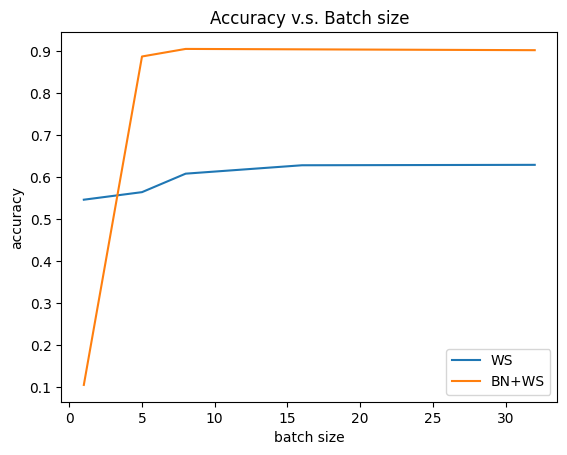

In [ ]:
plt.plot(result_BN_WS["batch_size"], result_BN_WS["accuracy"])
plt.plot(result_WS["batch_size"], result_WS["accuracy"])
plt.title("Accuracy v.s. Batch size")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend(['WS', 'BN+WS'], loc='lower right')
plt.show()

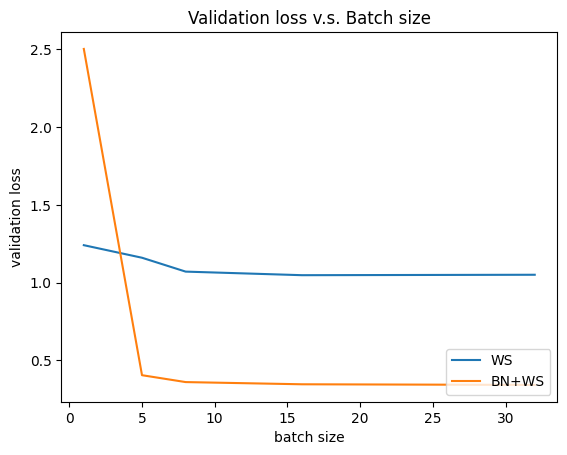

In [ ]:
plt.plot(result_BN_WS["batch_size"], result_BN_WS["val_loss"])
plt.plot(result_WS["batch_size"], result_WS["val_loss"])
plt.xlabel("batch size")
plt.ylabel("validation loss")
plt.title("Validation loss v.s. Batch size")
plt.legend(['WS', 'BN+WS'], loc='lower right')
plt.show()

---
# Applied to a larger dataset

To show the scalability of batch normalization we used the dataset available in (https://www.openml.org/search?type=data&status=active&id=265). It has 137k data points, that can be classified in 7 categories using 9 features.

We decided to use the same architecture as in the MNIST experiment, with a larger batch size.

In [ ]:
# Load data
data = fetch_openml(name='BNG(glass)', version=1, as_frame=True)
X, y = data.data, data.target

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split & scale
train_size = int(0.8*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_encoded[:train_size], y_encoded[train_size:]

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

print((X_train.shape))
print(np.unique(y_encoded))
print(X_test.shape)

(110224, 9)
[0 1 2 3 4 5 6]
(27557, 9)


In [ ]:
batch_size = 64
## Build the BN model
model_BN_larger = keras.models.Sequential([
    keras.layers.Dense(100,input_shape=(9,), kernel_initializer='random_normal'),
    BatchNormLayer(batch_size=batch_size),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal'),
    BatchNormLayer(batch_size=batch_size),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal', name='last_hidden'),
    BatchNormLayer(batch_size=batch_size),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(7, activation='softmax')
])



model_BN_larger.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_BN_larger= model_BN_larger.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

Epoch 1/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.4928 - loss: 1.4183 - val_accuracy: 0.5625 - val_loss: 1.1571
Epoch 2/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5651 - loss: 1.1479 - val_accuracy: 0.5672 - val_loss: 1.1284
Epoch 3/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5770 - loss: 1.1179 - val_accuracy: 0.5748 - val_loss: 1.1153
Epoch 4/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5813 - loss: 1.1074 - val_accuracy: 0.5808 - val_loss: 1.1067
Epoch 5/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5888 - loss: 1.0869 - val_accuracy: 0.5782 - val_loss: 1.0983
Epoch 6/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5898 - loss: 1.0777 - val_accuracy: 0.5844 - val_loss: 1.0890
Epoch 7/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5944 - loss: 1.0692 - val_accuracy: 0.5956 - val_loss: 1.0816
Epoch 8/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5963 - loss: 1.0636 

In [ ]:

## Build the BN model
model_base_larger = keras.models.Sequential([
    keras.layers.Dense(100,input_shape=(9,), kernel_initializer='random_normal'),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal'),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal', name='last_hidden'),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(7, activation='softmax')
])



model_base_larger.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_base_larger= model_base_larger.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

Epoch 1/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3393 - loss: 1.5536 - val_accuracy: 0.3561 - val_loss: 1.5266
Epoch 2/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3449 - loss: 1.5238 - val_accuracy: 0.3561 - val_loss: 1.4765
Epoch 3/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4202 - loss: 1.3626 - val_accuracy: 0.5073 - val_loss: 1.2231
Epoch 4/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5073 - loss: 1.2147 - val_accuracy: 0.4977 - val_loss: 1.2231
Epoch 5/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5135 - loss: 1.2115 - val_accuracy: 0.5097 - val_loss: 1.2169
Epoch 6/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5190 - loss: 1.2103 - val_accuracy: 0.5169 - val_loss: 1.2137
Epoch 7/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5260 - loss: 1.2019 - val_accuracy: 0.5288 - val_loss: 1.2024
Epoch 8/20
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5336 - loss: 1.1924 

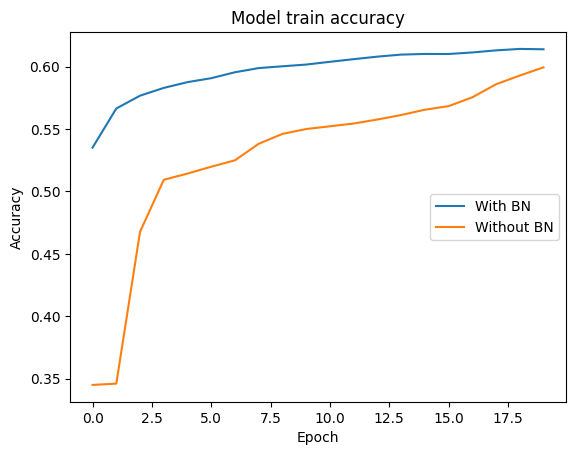

In [ ]:
# Plot
# Models Train Accuracy
plt.plot(history_BN_larger.history['accuracy'])
plt.plot(history_base_larger.history['accuracy'])
plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With BN', 'Without BN'], loc='center right')
plt.show()

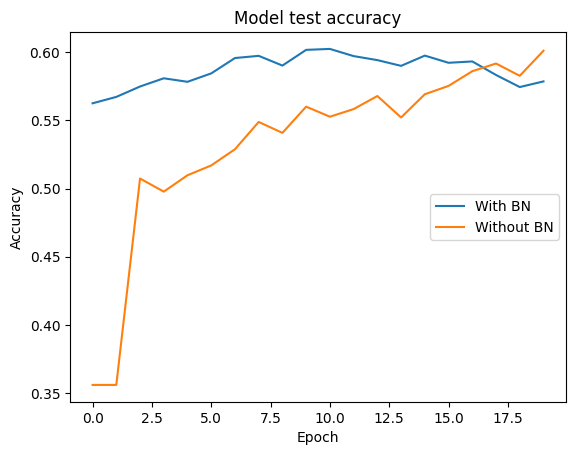

In [ ]:
# Plot
# Models Test Accuracy
plt.plot(history_BN_larger.history['val_accuracy'])
plt.plot(history_base_larger.history['val_accuracy'])
plt.title('Model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With BN', 'Without BN'], loc='center right')
plt.show()

862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


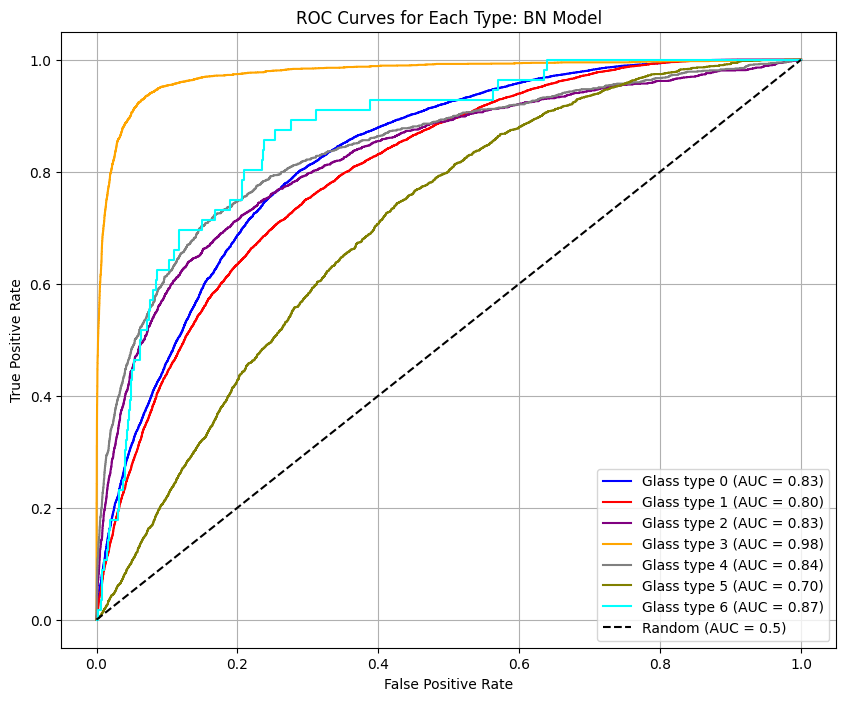

In [ ]:
# Second measurment metric
# We will plot the ROC curve for each class

# Convert true labels to one-hot encoded format
y_true_bin = label_binarize(y_test, classes=np.arange(10))  # Shape: (n_samples, 10)

# BN model
y_probs_BN = model_BN_larger.predict(X_test)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'purple', 'orange',
           'gray', 'olive', 'cyan']

for i in range(7):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_BN[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'Glass type {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Type: BN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


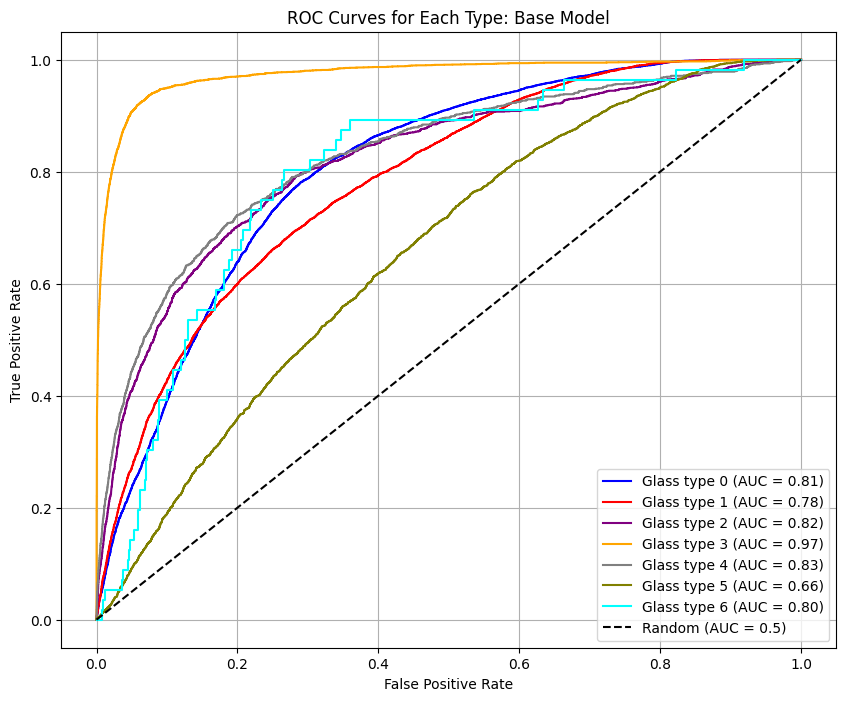

In [ ]:
# Base model
y_probs_base = model_base_larger.predict(X_test)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'purple', 'orange',
           'gray', 'olive', 'cyan']
for i in range(7):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'Glass type {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Type: Base Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---
---
# A More Straight-Forward approach

It is also possible to use the built-in Batch Normalization layer from Tensorflow.

In [ ]:
!pip install python-mnist

In [ ]:
#load mnist data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_BN = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, kernel_initializer='random_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(100, kernel_initializer='random_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model_base = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation = 'sigmoid', kernel_initializer='random_normal'),
    keras.layers.Dense(100, activation = 'sigmoid', kernel_initializer='random_normal'),
    keras.layers.Dense(100, activation = 'sigmoid', kernel_initializer='random_normal'),
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
batch_size = 60
steps_per_epoch = len(train_images) / batch_size
steps = 50000
epochs = int(steps/steps_per_epoch)


model_BN.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_model_BN = model_BN.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size,
             validation_data=(test_images, test_labels))


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9829 - loss: 0.0610 - val_accuracy: 0.9647 - val_loss: 0.1355
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9829 - loss: 0.0600 - val_accuracy: 0.9632 - val_loss: 0.1377
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9826 - loss: 0.0605 - val_accuracy: 0.9640 - val_loss: 0.1331
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9844 - loss: 0.0571 - val_accuracy: 0.9650 - val_loss: 0.1389
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9836 - loss: 0.0572 - val_accuracy: 0.9647 - val_loss: 0.1394
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9852 - loss: 0.0542 - val_accuracy: 0.9653 - val_loss: 0.1368
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9863 - loss: 0.0520 - val_accuracy: 0.9659 - val_loss: 0.1353
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9873 - loss: 0.05

In [ ]:
model_base.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0012, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_model_base = model_base.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size,
             validation_data=(test_images, test_labels))

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1153 - loss: 2.3208 - val_accuracy: 0.1162 - val_loss: 2.2846
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1728 - loss: 2.2791 - val_accuracy: 0.3208 - val_loss: 2.2523
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2887 - loss: 2.2370 - val_accuracy: 0.4092 - val_loss: 2.1606
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3692 - loss: 2.1139 - val_accuracy: 0.4178 - val_loss: 1.8996
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4450 - loss: 1.8052 - val_accuracy: 0.4964 - val_loss: 1.5039
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5340 - loss: 1.4344 - val_accuracy: 0.6194 - val_loss: 1.2395
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6523 - loss: 1.1930 - val_accuracy: 0.7097 - val_loss: 1.0225
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7328 - loss: 0.9674 - 

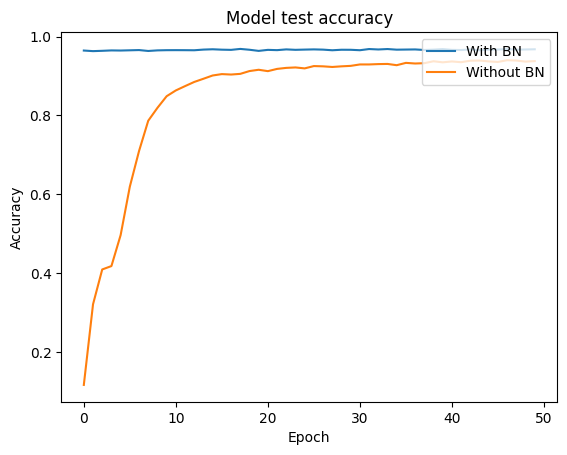

In [ ]:
plt.plot(history_model_BN.history['val_accuracy'])
plt.plot(history_model_base.history['val_accuracy'])
plt.title('Model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With BN', 'Without BN'], loc='upper right')
plt.show()